In [1]:
import pymysql
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [2]:
import os

host_name = os.getenv('HOST_NAME')
passwd = os.getenv('AWS_PASSWORD')
user='group2'
database='group2db'

In [3]:
# Connecting AWS mysql Database
con = pymysql.connect(host=host_name,user=user,passwd=passwd,db=database)

In [4]:
# Reading sql table into pandas DataFrame
tweet_df = pd.read_sql_query('''select * from tweets_locations2''', con)

In [5]:
tweet_df

,tweet_id,tweet,location
0,1,RT @laggy_mads: Y’all got me fucked up if you ...,Oregon
1,2,I've been trying to sign my 102-year-old grand...,New York
2,3,Pro-life my ass.????,Colorado
3,4,RT @ImmunoFever: Every single vaccination plac...,Arizona
4,5,RT @WSJ: U.S. officials will suggest anyone ov...,New York
...,...,...,...
4036,4037,The news I’ve been waiting for!,New York
4037,4038,Silver lining of a very dark cloud (Covid) bri...,New Hampshire
4038,4039,"RT @mjcontrera: There are some 70,000 American...",California
4039,4040,RT @DoctorAngry: On @BBCNews I have just seen...,Louisiana


In [6]:
tweet_df = tweet_df.drop(columns=['tweet_id'], axis=1)

In [7]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4041 entries, 0 to 4040
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet     4041 non-null   object
 1   location  4041 non-null   object
dtypes: object(2)
memory usage: 63.3+ KB


In [8]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [9]:
#  Function to clean the tweets
def remove_punc(message):
    Test_punc_removed = [ char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    return Test_punc_removed_join
tweet_df['tweet'] = tweet_df['tweet'].apply(remove_punc)
tweet_df

,tweet,location
0,RT laggymads Y’all got me fucked up if you thi...,Oregon
1,Ive been trying to sign my 102yearold grandfat...,New York
2,Prolife my ass,Colorado
3,RT ImmunoFever Every single vaccination place ...,Arizona
4,RT WSJ US officials will suggest anyone over 6...,New York
...,...,...
4036,The news I’ve been waiting for,New York
4037,Silver lining of a very dark cloud Covid bring...,New Hampshire
4038,RT mjcontrera There are some 70000 Americans w...,California
4039,RT DoctorAngry On BBCNews I have just seen la...,Louisiana


In [10]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','will','aap','co','day','user','tweet','today','week','year', 'https','httpstco', 'rt', 'RT'])

In [11]:
# Remove stopwords and remove short words (less than 2 characters)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words and len(token) >= 2:
            result.append(token)
    return result
tweet_df['tweet'] = tweet_df['tweet'].apply(preprocess).apply(lambda x: " ".join(x))
tweet_df

,tweet,location
0,laggymads got fucked think getting covid vaccine,Oregon
1,ive trying sign yearold grandfather get covid ...,New York
2,prolife ass,Colorado
3,immunofever every single vaccination place nee...,Arizona
4,wsj us officials suggest anyone preexisting co...,New York
...,...,...
4036,news waiting,New York
4037,silver lining dark cloud covid brings promisin...,New Hampshire
4038,mjcontrera americans disabilities living group...,California
4039,doctorangry bbcnews seen lay people trained gi...,Louisiana


In [12]:
# Function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Creating two new columns Subjectivity, Polarity
tweet_df['Subjectivity'] = tweet_df['tweet'].apply(getSubjectivity)
tweet_df['Polarity'] = tweet_df['tweet'].apply(getPolarity)

In [13]:
tweet_df

,tweet,location,Subjectivity,Polarity
0,laggymads got fucked think getting covid vaccine,Oregon,0.700000,-0.600000
1,ive trying sign yearold grandfather get covid ...,New York,0.000000,0.000000
2,prolife ass,Colorado,0.000000,0.000000
3,immunofever every single vaccination place nee...,Arizona,0.416667,0.238095
4,wsj us officials suggest anyone preexisting co...,New York,0.800000,0.400000
...,...,...,...,...
4036,news waiting,New York,0.000000,0.000000
4037,silver lining dark cloud covid brings promisin...,New Hampshire,0.451515,0.062121
4038,mjcontrera americans disabilities living group...,California,0.000000,0.000000
4039,doctorangry bbcnews seen lay people trained gi...,Louisiana,0.000000,0.000000


In [14]:
# Create a function to compute the negative, neutral and positive analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return "Neutral"
    else:
        return 'Positive'

tweet_df['Analysis'] = tweet_df['Polarity'].apply(getAnalysis)

tweet_df

,tweet,location,Subjectivity,Polarity,Analysis
0,laggymads got fucked think getting covid vaccine,Oregon,0.700000,-0.600000,Negative
1,ive trying sign yearold grandfather get covid ...,New York,0.000000,0.000000,Neutral
2,prolife ass,Colorado,0.000000,0.000000,Neutral
3,immunofever every single vaccination place nee...,Arizona,0.416667,0.238095,Positive
4,wsj us officials suggest anyone preexisting co...,New York,0.800000,0.400000,Positive
...,...,...,...,...,...
4036,news waiting,New York,0.000000,0.000000,Neutral
4037,silver lining dark cloud covid brings promisin...,New Hampshire,0.451515,0.062121,Positive
4038,mjcontrera americans disabilities living group...,California,0.000000,0.000000,Neutral
4039,doctorangry bbcnews seen lay people trained gi...,Louisiana,0.000000,0.000000,Neutral


In [15]:
tweet_df.to_csv("TwitterSentimentData.csv")

Text(0.5, 1.0, 'Twitter Sentiment Analysis')

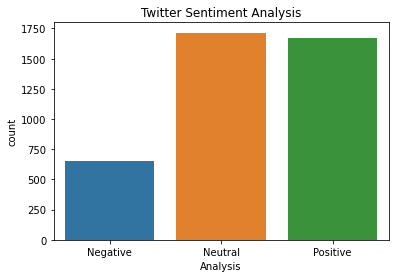

In [16]:
sns.countplot(tweet_df['Analysis']).set_title('Twitter Sentiment Analysis')

<Figure size 1440x1440 with 0 Axes>

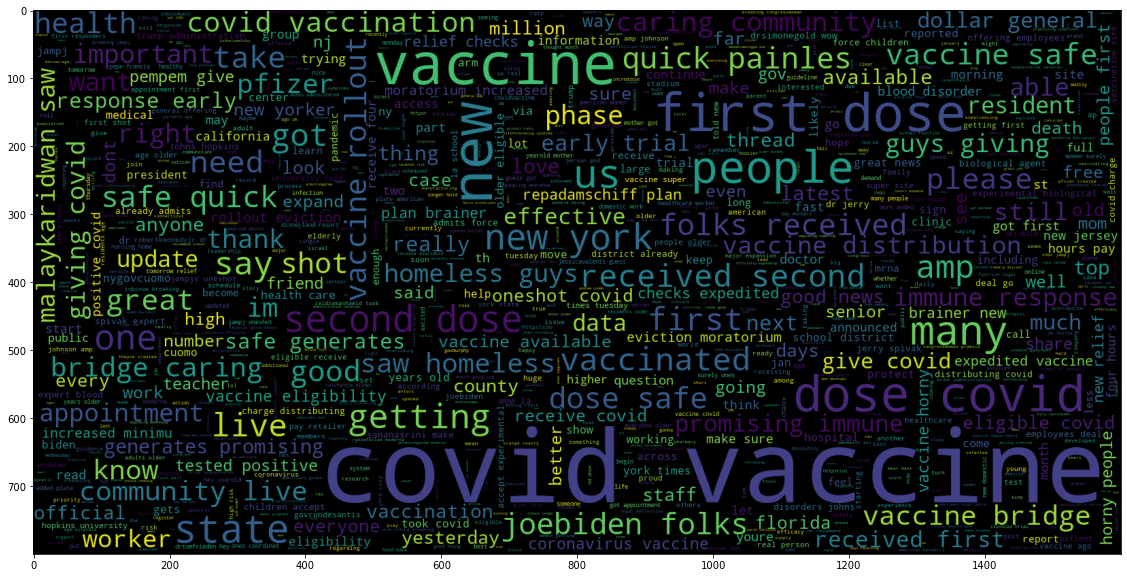

In [17]:
#positive sentiment
plt.figure(figsize= (20, 20))
wc = WordCloud(max_words = 900, width = 1600, height = 800).generate(" ".join(tweet_df[tweet_df['Polarity'] > 0.0]['tweet']))
plt.figure(figsize=(20, 10), facecolor='white', edgecolor='blue')

plt.imshow(wc)

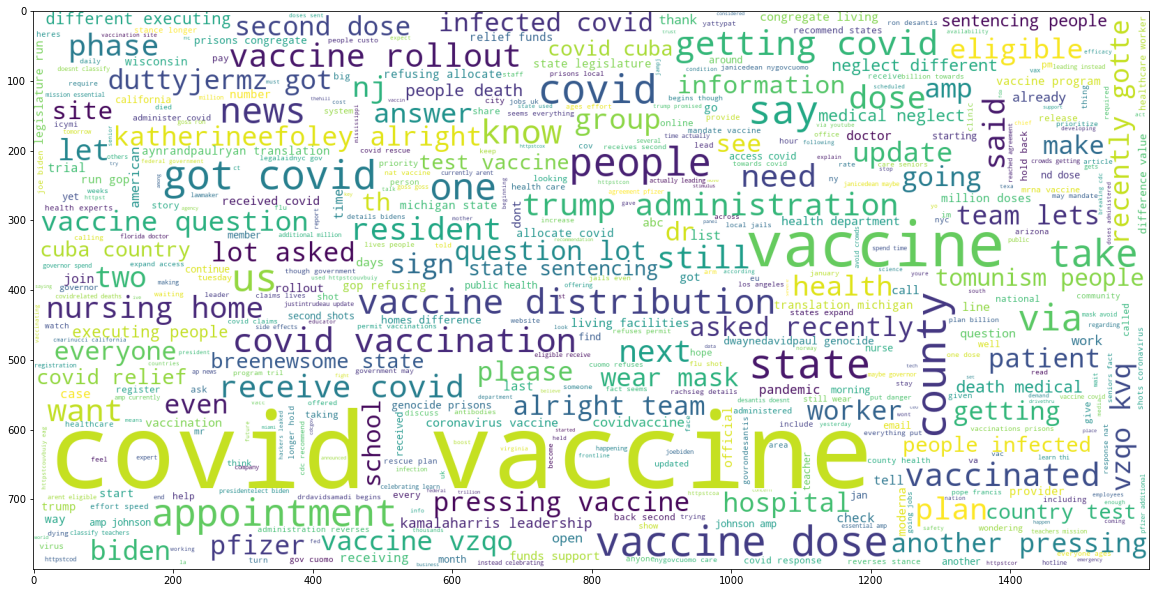

In [18]:
# nutral sentiment word cloud

plt.figure(figsize= (20, 20))
wc = WordCloud(background_color='white', max_words = 500, width = 1600, height = 800).generate(" ".join(tweet_df[tweet_df['Polarity'] == 0.0]['tweet']))
plt.imshow(wc)

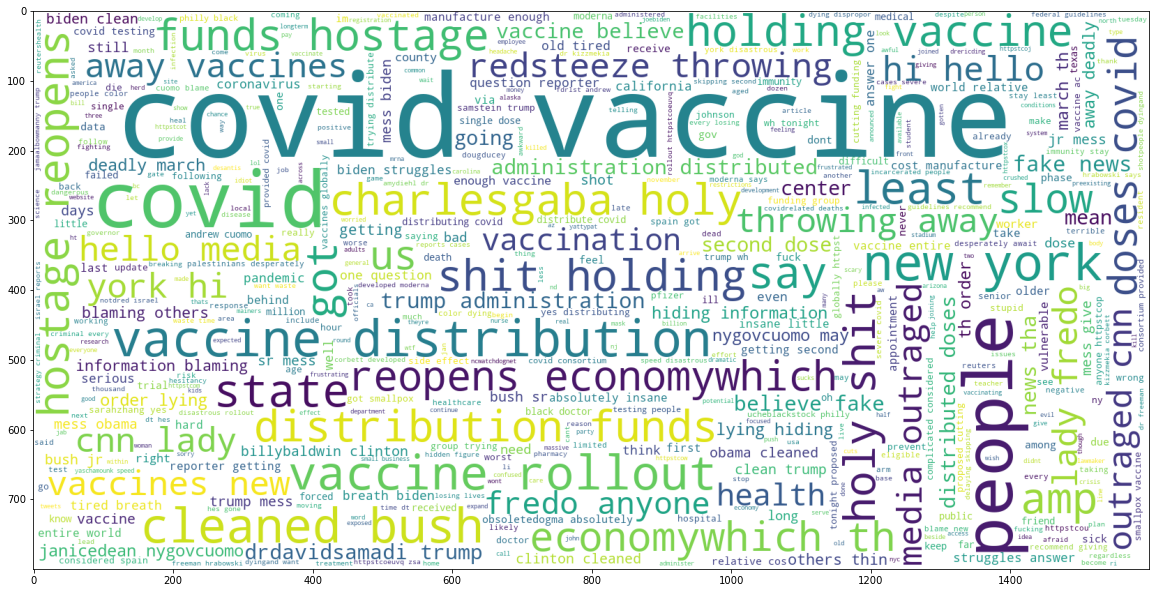

In [19]:
# negative sentiment word cloud

plt.figure(figsize= (20, 20))
wc = WordCloud(background_color='white', max_words = 500, width = 1600, height = 800).generate(" ".join(tweet_df[tweet_df['Polarity'] < 0.0]['tweet']))
plt.imshow(wc)

In [20]:
list_of_words = []
# for i in tweet_df['tweet']:
for i in tweet_df['tweet'].str.split(' '):
    for j in i:
        list_of_words.append(j)

In [21]:
total_words = len(list(set(list_of_words)))
total_words

10484

In [22]:
# split the data into test and train

X = tweet_df['tweet'].str.split(' ')
y = tweet_df['Polarity']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [23]:
# X_train

In [24]:
# X_test

In [25]:
X_train.shape

(3030,)

In [26]:
X_test.shape

(1011,)

In [27]:
y_train.shape

(3030,)

In [28]:
# create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(X_train)

# Training data
train_sequences = tokenizer.texts_to_sequences(X_train)

# Testing data
test_sequences = tokenizer.texts_to_sequences(X_test)

In [29]:
print('The encoding for document\n', X_train[1:2], 'is:', train_sequences[1])

The encoding for document
 493    [nj, repbonnie, watson, coleman, tested, posit...
Name: tweet, dtype: object is: [69, 2017, 2018, 2019, 166, 167, 2, 780, 2020, 1251, 3199, 2021]


In [30]:
# Add padding to training and testing
padded_train = pad_sequences(train_sequences, maxlen=29)
padded_test = pad_sequences(test_sequences, maxlen=29)

In [31]:
for i, doc in enumerate(padded_train[:3]):
    print('The padded encoding for document:',  i+1, 'is', doc)

The padded encoding for document: 1 is [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0 1542  557 1050  905  505   23   26 1051 3197
 3198]
The padded encoding for document: 2 is [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   69 2017 2018 2019  166  167    2  780 2020 1251 3199
 2021]
The padded encoding for document: 3 is [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0 3200   89  110  906  146  261   26    2    1
 2022]


In [32]:
y_train

3530    0.057143
493     0.227273
3837    0.000000
1928    0.270833
3911    0.000000
          ...   
835     0.058333
3264    0.000000
1653    0.000000
2607    0.800000
2732    0.500000
Name: Polarity, Length: 3030, dtype: float64

In [33]:
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

In [34]:
y_train_cat.shape

(3030, 2)

In [35]:
y_test_cat.shape

(1011, 2)

In [36]:
y_train_cat

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [37]:
# Sequential model
model = Sequential()
model.add(Embedding(total_words, output_dim = 512))

model.add(LSTM(1))

model.add(Dense(1, activation = 'relu'))

model.add(Dropout(0.3))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 512)         5367808   
_________________________________________________________________
lstm (LSTM)                  (None, 1)                 2056      
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
_________________________________________________________________
dropout (Dropout)            (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4         
Total params: 5,369,870
Trainable params: 5,369,870
Non-trainable params: 0
_________________________________________________________________


In [38]:
# train the model
model.fit(padded_train, y_train_cat, validation_split=0.05, epochs = 2)

Epoch 1/2
90/90 [==============================] - 12s 107ms/step - loss: 0.5350 - acc: 0.9911 - val_loss: 0.3509 - val_acc: 0.9934
Epoch 2/2
90/90 [==============================] - 7s 80ms/step - loss: 0.3404 - acc: 0.9932 - val_loss: 0.2217 - val_acc: 0.9934


In [39]:
# make prediction
pred = model.predict(padded_test)

In [40]:
# pred

In [41]:
# make prediction
# argmax finds the argument that gives the maximum value to find the class with the highest probability(predictions).
#index of maximum number
prediction = []
for i in pred:
    prediction.append(np.argmax(i))

In [42]:
# prediction

In [43]:
# Prediction
# list containing original values
original = []
for i in y_test_cat:
    original.append(np.argmax(i))

In [44]:
# original

In [45]:
# accuracy score on text data
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(original, prediction)

In [46]:
accuracy

0.9910979228486647

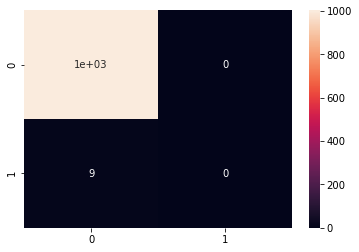

In [47]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot = True)